# Librerías

In [1]:
import numpy as np 
import pandas as pd
import joblib
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from skimage import feature, data, color 
import os
from tqdm import tqdm 
from skimage.transform import resize 
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain 
from scipy import stats 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

#Metricas de performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Importar Caras y Fondos

In [2]:
face_suffix = '.pgm'
face_dir = os.listdir('Faces/')
pgm_files = [filename for filename in face_dir if filename.endswith(face_suffix)]

face_suffix = '.png'
fondos_dir = os.listdir('Generar_Fondos/generated_patches/')
png_files = [filename for filename in fondos_dir if filename.endswith(face_suffix)]

positive_patches = []
for filename in tqdm(pgm_files):
    path = 'Faces/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        positive_patches.append (image)

negative_patches = []
for filename in tqdm(png_files):
    path = 'Generar_Fondos/generated_patches/' + filename
    with open (path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        negative_patches.append(image)
    

100%|██████████| 12800/12800 [00:02<00:00, 4599.42it/s]


In [3]:
positive_patches = np.array(positive_patches)
negative_patches = np.array(negative_patches)

# Take half of positive patches randomly
np.random.seed(42)  # For reproducibility
half_size = len(positive_patches) // 2
indices = np.random.choice(len(positive_patches), half_size, replace=False)
positive_patches = positive_patches[indices]

print(positive_patches.shape)
print(negative_patches.shape)

(6416, 64, 64)
(12800, 64, 64)


In [4]:
P = len(positive_patches)

In [5]:
X = np. array([feature.hog(im) for im in tqdm(chain(positive_patches, negative_patches), desc='Construyendo X') ])
y = np. zeros(len(X))
y[:P] = 1 # 1 es positivo, 0 es negativo

Construyendo X: 19216it [00:07, 2522.15it/s]


In [6]:
# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# PCA

In [7]:
# Aplicar PCA para reducir la dimensionalidad
pca = PCA(n_components=500)
x_pca = pca.fit(X)
x_transform = pca.transform(X)

X_train_pca = pca.fit_transform(X_train)

In [8]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Obtener varianzas
var_explicada = x_pca.explained_variance_ratio_ 
var_acumulada = np.cumsum(var_explicada)

# Crear DataFrames para Plotly
df_var_explicada = pd.DataFrame({
    'Componente': range(1, len(var_explicada)+1),
    'Varianza': var_explicada
})

df_var_acumulada = pd.DataFrame({
    'Componente': range(1, len(var_acumulada)+1),
    'Varianza': var_acumulada
})

# Crear subplots usando Plotly Express
fig = make_subplots(rows=1, cols=2, subplot_titles=('Varianza explicada por componente', 'Varianza acumulada'))

# Varianza explicada
fig.add_trace(
    go.Bar(
        x=df_var_explicada['Componente'], 
        y=df_var_explicada['Varianza'], 
        name='Varianza explicada',
        marker_color='#1f77b4',  # Azul más oscuro
        opacity=0.8
    ),
    row=1, col=1
)

# Varianza acumulada
fig.add_trace(
    go.Bar(
        x=df_var_acumulada['Componente'], 
        y=df_var_acumulada['Varianza'], 
        name='Varianza acumulada',
        marker_color='#2ca02c',  # Verde más oscuro
        opacity=0.8
    ),
    row=1, col=2
)

# Agregar línea de 95% de varianza
fig.add_hline(
    y=0.95, 
    line_dash="dash", 
    line_color="red",
    line_width=2,
    row=1, 
    col=2
)

# Actualizar layout
fig.update_layout(
    height=500,
    width=1200,
    showlegend=True,
    title_text="Análisis de Varianza PCA",
    title_font_size=20,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis_title="Componente principal",
    yaxis_title="Proporción de varianza",
    xaxis2_title="Componente principal",
    yaxis2_title="Proporción de varianza",
    font=dict(size=12),
    margin=dict(t=100)
)

# Actualizar ejes para mejor visualización
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

fig.show()

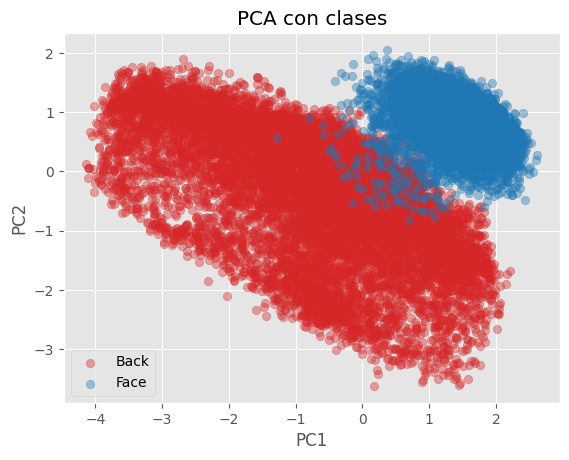

In [9]:
# Tomar solo las primeras dos componentes para graficar
X_plot = x_transform[:, :2]


# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Back', 'Face']

for class_value in [0, 1]:
    plt.scatter(x_transform[y == class_value, 0], x_transform[y == class_value, 1], c=colors [class_value], label=labels[class_value], alpha=0.4)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()

# Models

In [10]:
# Separar en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(x_transform, y, test_size=0.2, random_state=42)

X_test_pca = pca.transform(X_test)

In [11]:
print(X_train_pca.shape)
print(X_test_pca.shape)
print(y_train.shape)
print(y_test.shape)

(13451, 500)
(5765, 500)
(13451,)
(5765,)


In [12]:
#Algorimtos de clasificacion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from re import A


In [13]:
X_train = X_train_pca

X_test = X_test_pca

## KNN

In [14]:
# Elegimos el k
k = 3

In [15]:
knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [16]:
y_train_pred =knn.predict(X_train)
y_test_pred = knn.predict(X_test)

print('Accuracy train:',accuracy_score(y_train,y_train_pred))
print('Accuracy test: ',accuracy_score(y_test,y_test_pred))

Accuracy train: 0.9977696825514831
Accuracy test:  0.9930615784908933


In [17]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8935
         1.0       1.00      1.00      1.00      4516

    accuracy                           1.00     13451
   macro avg       1.00      1.00      1.00     13451
weighted avg       1.00      1.00      1.00     13451



In [18]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3865
         1.0       0.99      0.99      0.99      1900

    accuracy                           0.99      5765
   macro avg       0.99      0.99      0.99      5765
weighted avg       0.99      0.99      0.99      5765



In [19]:
joblib.dump(knn, 'models/knn_model.joblib')

['models/knn_model.joblib']

### Implementar GridSearch para buscar la mejor k

In [20]:
from sklearn.model_selection import GridSearchCV

# 1. Definir el clasificador
knn = KNeighborsClassifier(metric='euclidean') 

# 2. Definir el rango de parámetros a buscar
param_grid = {
    'n_neighbors': list(range(1, 51, 2))
}

# Puedes ajustar este rango según tu problema y la cantidad de datos que tengas.
# Si tienes muchos datos, 'k' puede ser más grande.

# 3. Configurar GridSearchCV
# cv: número de folds para la validación cruzada (por ejemplo, 5 o 10)
# scoring: la métrica que se usará para evaluar los modelos (por ejemplo, 'accuracy')
# n_jobs: número de CPUs a usar (-1 significa usar todos los disponibles)
grid_search = GridSearchCV(estimator=knn,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1) # verbose=1 para ver el progreso

# 4. Ejecutar la búsqueda en cuadrícula en los datos de entrenamiento
print("Iniciando GridSearchCV...")
grid_search.fit(X_train, y_train)
print("GridSearchCV finalizado.")

# 5. Obtener los mejores resultados
print(f"Mejor parámetro 'k' (n_neighbors): {grid_search.best_params_['n_neighbors']}")
print(f"Mejor score (accuracy) en validación cruzada: {grid_search.best_score_:.4f}")

# 6. Evaluar el mejor modelo en el conjunto de prueba
best_knn = grid_search.best_estimator_

y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

print('\nResultados del mejor modelo:')
print('Accuracy train:', accuracy_score(y_train, y_train_pred))
print('Accuracy test: ', accuracy_score(y_test, y_test_pred))


Iniciando GridSearchCV...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
GridSearchCV finalizado.
Mejor parámetro 'k' (n_neighbors): 3
Mejor score (accuracy) en validación cruzada: 0.9960

Resultados del mejor modelo:
Accuracy train: 0.9977696825514831
Accuracy test:  0.9930615784908933


In [21]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8935
         1.0       1.00      1.00      1.00      4516

    accuracy                           1.00     13451
   macro avg       1.00      1.00      1.00     13451
weighted avg       1.00      1.00      1.00     13451



In [22]:
joblib.dump(best_knn, 'models/best_knn_model.joblib')

['models/best_knn_model.joblib']

## Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

In [24]:
model = GaussianNB()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# print('Accuracy train:',accuracy_score(y_train,y_train_pred))
# print('Accuracy test: ',accuracy_score(y_test,y_test_pred))

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      8935
         1.0       0.94      0.92      0.93      4516

    accuracy                           0.96     13451
   macro avg       0.95      0.95      0.95     13451
weighted avg       0.96      0.96      0.96     13451



In [25]:
# X_test
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      3865
         1.0       0.96      0.89      0.92      1900

    accuracy                           0.95      5765
   macro avg       0.95      0.94      0.94      5765
weighted avg       0.95      0.95      0.95      5765



In [26]:
joblib.dump(model, 'models/nb_model.joblib')

['models/nb_model.joblib']

## Decision Tree

In [27]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [28]:
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3865
         1.0       0.98      0.98      0.98      1900

    accuracy                           0.99      5765
   macro avg       0.98      0.98      0.98      5765
weighted avg       0.99      0.99      0.99      5765



In [29]:
joblib.dump(clf, 'models/tree_model.joblib')

['models/tree_model.joblib']